In [2]:
import os
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px


1 - Importación y Limpieza de Datos

In [ ]:
# ======================================================
# 📝 Instrucciones Iniciales e Importación de Archivos
# ======================================================
print("Antes de comenzar, revisa que los archivos CSV ('Hendylaset - ordenes.csv' y 'Hendylaset - cart-items.csv') estén en la misma carpeta que este notebook.")

# Obtengo la ruta del directorio actual

current_dir = os.getcwd()

# Defino la subcarpeta 'datasets'
dataset_folder = os.path.join(current_dir, "Datasets")

# Apunto a los archivos dentro de esa carpeta
file_orders = os.path.join(dataset_folder, "Hendylaset - ordenes.csv")
file_cart   = os.path.join(dataset_folder, "Hendylaset - cart-items.csv")

# Verifico si los archivos existen antes de cargarlos
if os.path.exists(file_orders) and os.path.exists(file_cart):
    # Si existen, cargo los datos en DataFrames
    df_orders = pd.read_csv(file_orders)
    df_cart   = pd.read_csv(file_cart)
    print("✅ Archivos cargados correctamente.")
else:
    # Si no existen, detengo la ejecución y muestro error
    print("❌ Error: No se encontraron los archivos CSV. Verifica la ruta o los nombres de los archivos.")
    raise FileNotFoundError("No se encontraron los archivos de datos. Revisa su ubicación o el nombre.")

# Muestro las primeras filas de cada dataset para una revisión inicial
print("\n👉 Primeras filas de df_orders:")
display(df_orders.head())

print("\n👉 Primeras filas de df_cart:")
display(df_cart.head())

# Reviso de forma general la información de cada dataset
print("\nInformación del dataset de órdenes:")
display(df_orders.info())

print("\nInformación del dataset de carritos:")
display(df_cart.info())


# ======================================================
# 1️⃣ Conversión de Fechas
# ======================================================
# Convierto las columnas de fecha a formato datetime para evitar inconsistencias
if 'timestamp_created' in df_orders.columns:
    df_orders["timestamp_created"] = pd.to_datetime(df_orders["timestamp_created"], errors="coerce")
if 'added_to_cart' in df_cart.columns:
    df_cart["added_to_cart"] = pd.to_datetime(df_cart["added_to_cart"], errors="coerce")


# ======================================================
# 2️⃣ Conversión de Columnas Numéricas
# ======================================================
# Defino las columnas que deberían ser numéricas en cada dataset
num_cols_orders = ["total_cobrado", "dto", "cantidad", "pounds"]
num_cols_cart   = ["pounds_item", "quantity", "precio_unit"]

# Convierto a valores numéricos usando 'coerce' para forzar NaN en caso de error
for col in num_cols_orders:
    if col in df_orders.columns:
        df_orders[col] = pd.to_numeric(df_orders[col], errors="coerce")

for col in num_cols_cart:
    if col in df_cart.columns:
        df_cart[col] = pd.to_numeric(df_cart[col], errors="coerce")


# ======================================================
# 3️⃣ Revisión de Valores Nulos Antes de la Imputación
# ======================================================
print("\n👉 Valores nulos ANTES de la imputación:")
print("\nDataset de órdenes:")
display(df_orders.isnull().sum())
print("\nDataset de carritos:")
display(df_cart.isnull().sum())


# ======================================================
# 4️⃣ Limpieza y Transformación en df_cart
# ======================================================
# ---------- Limpieza de 'shipping_type' ----------
# Umbral de 1% para agrupar valores poco frecuentes como "Desconocido"
threshold_shipping = 0.01
shipping_freq = df_cart['shipping_type'].value_counts(normalize=True)
rare_shipping_types = shipping_freq[shipping_freq < threshold_shipping].index.tolist()

print("\nValores poco frecuentes en 'shipping_type':", rare_shipping_types)

# Reemplazo los valores poco frecuentes por "Desconocido"
df_cart['shipping_type'] = df_cart['shipping_type'].apply(
    lambda x: "Desconocido" if x in rare_shipping_types else x
)

# ---------- Limpieza de 'manufacturer' ----------
# Normalizo los nombres pasando a minúsculas y quitando espacios
df_cart['manufacturer_normalized'] = df_cart['manufacturer'].astype(str).str.lower().str.strip()

# Reviso la frecuencia de valores en la columna normalizada
manufacturer_freq = df_cart['manufacturer_normalized'].value_counts(normalize=True)
print("\nFrecuencia de valores en 'manufacturer_normalized':")
print(manufacturer_freq)

# Uso un umbral de 0.005% para determinar qué fabricantes son poco frecuentes
threshold_manufacturer = 0.00005
rare_manufacturers = manufacturer_freq[manufacturer_freq < threshold_manufacturer].index.tolist()
print("\nValores poco frecuentes en 'manufacturer_normalized':", rare_manufacturers)

# Reemplazo fabricantes muy poco frecuentes por "no disponible."
df_cart['manufacturer_normalized'] = df_cart['manufacturer_normalized'].apply(
    lambda x: "no disponible." if x in rare_manufacturers else x
)

# ---------- Revisión de 'category' ----------
null_category_count = df_cart['category'].isnull().sum()
print("\nCantidad de valores nulos en 'category':", null_category_count)
print("\nResumen de la columna 'category':")
display(df_cart['category'].value_counts(dropna=False))


# ======================================================
# 5️⃣ Imputación de Valores Nulos
# ======================================================
# Relleno valores nulos en df_orders y df_cart con valores por defecto o medianas
df_orders.fillna({"estado": "desconocido", "depto": "desconocido"}, inplace=True)
df_cart.fillna({
    "shipping_type": "desconocido",
    "category": "desconocida",
    "pounds_item": df_cart["pounds_item"].median(),
    "manufacturer": "desconocido"
}, inplace=True)

# Reviso nuevamente los nulos tras la imputación
print("\n👉 Valores nulos DESPUÉS de la imputación:")
print("\nDataset de órdenes:")
display(df_orders.isnull().sum())
print("\nDataset de carritos:")
display(df_cart.isnull().sum())


# ======================================================
# 6️⃣ Corrección de Descuentos Inválidos en df_orders
# ======================================================
# Genero una columna auxiliar con el valor absoluto de 'dto' para compararlo
df_orders['descuento_abs'] = df_orders['dto'].abs()

# Detecto filas donde el descuento supere o iguale al total cobrado
invalid_discounts_mask = df_orders['descuento_abs'] >= df_orders['total_cobrado']
print(f"\nRegistros con descuentos inválidos: {invalid_discounts_mask.sum()}")

# Asigno 0 a 'dto' en los registros que resulten inválidos
df_orders.loc[invalid_discounts_mask, 'dto'] = 0
print("✅ Descuentos inválidos corregidos.")


# ======================================================
# 7️⃣ Cálculo del Porcentaje de Descuento
# ======================================================
# Aseguro que 'total_cobrado' sea positivo y calculo el % de descuento
df_orders['total_cobrado'] = df_orders['total_cobrado'].abs()
df_orders['porcentaje_descuento'] = np.where(
    df_orders['total_cobrado'] > 0,
    np.round((df_orders['dto'].abs() / df_orders['total_cobrado']) * 100),
    0
)

print("\nSe agregó la columna 'porcentaje_descuento':")
display(df_orders[['dto', 'total_cobrado', 'porcentaje_descuento']].head())


# ======================================================
# 8️⃣ Revisión y Limpieza de 'quantity' en df_cart
# ======================================================
if 'quantity' in df_cart.columns:
    # 1. Identifico valores flotantes menores a 1 (que no tendrían sentido en cantidad)
    invalid_floats = df_cart[(df_cart['quantity'].apply(lambda x: isinstance(x, float))) & (df_cart['quantity'] < 1)]
    
    # 2. Identifico valores de tipo string o que contengan caracteres no numéricos
    invalid_strings = df_cart[df_cart['quantity'].apply(lambda x: isinstance(x, str) or not str(x).replace('.', '', 1).isdigit())]
    
    # 3. Combino ambos conjuntos de registros inválidos
    invalid_quantity = pd.concat([invalid_floats, invalid_strings])
    
    print(f"\nRegistros con valores inválidos en 'quantity': {invalid_quantity.shape[0]}")
    display(invalid_quantity)
    
    # Elimino las filas que no cumplen con los criterios de cantidad válida
    df_cart = df_cart.drop(invalid_quantity.index)
else:
    print("\n⚠️ La columna 'quantity' no existe en df_cart.")


# ======================================================
# 9️⃣ Guardar Datasets Limpios
# ======================================================
# Finalmente, guardo los DataFrames limpios en nuevos CSV para su uso posterior
df_orders.to_csv("orders_cleaned.csv", index=False)
df_cart.to_csv("cart_cleaned.csv", index=False)

print("\n✅ Proceso de limpieza y transformación finalizado. Archivos 'orders_cleaned.csv' y 'cart_cleaned.csv' guardados.")


2 - Análisis del Time Lag entre Compras

In [4]:
# ======================================================
#  Creación de Conexión a SQLite en Memoria
# ======================================================
# Genero una base de datos en memoria y
# cargo en ella los datasets limpios para
# poder ejecutar consultas SQL fácilmente.

conn = sqlite3.connect(':memory:')

df_orders.to_sql('orders', conn, index=False, if_exists='replace')
df_cart.to_sql('cart', conn, index=False, if_exists='replace')

# ======================================================
#  Cálculo de Time Lag entre Compras
# ======================================================
# A continuación, defino una consulta SQL que:
#  1. Identifica a los usuarios que tengan más de una compra.
#  2. Para cada usuario, calcula la diferencia en días entre la compra actual
#     y la compra previa (usando la función LAG en SQL).
#  3. Excluye las filas en las que no existe un pedido previo (es decir, la primera compra de cada usuario).
# Esto me permitirá ver cuánto tiempo pasa entre compra y compra.

timelag_query = """
WITH orders_count AS (
    SELECT 
       customer AS user_id,       -- Ajustar el nombre de la columna de usuario si fuese diferente.
       COUNT(*) AS order_count
    FROM orders
    WHERE timestamp_created IS NOT NULL
    GROUP BY customer
),
orders_cte AS (
    SELECT 
       o.customer AS user_id,
       o.order_id,
       o.timestamp_created AS order_time,
       LAG(o.timestamp_created) OVER (PARTITION BY o.customer ORDER BY o.timestamp_created) AS prev_order_time
    FROM orders o
    WHERE o.timestamp_created IS NOT NULL
)
SELECT
   o.user_id,
   o.order_id,
   o.order_time,
   o.prev_order_time,
   ROUND(julianday(o.order_time) - julianday(o.prev_order_time)) AS days_between_orders
FROM orders_cte o
JOIN orders_count c ON o.user_id = c.user_id
WHERE c.order_count > 1
  AND o.prev_order_time IS NOT NULL;
"""

df_timelag = pd.read_sql_query(timelag_query, conn)
print("📌 Resultado del Time Lag entre compras (días) para usuarios con más de una orden:")
display(df_timelag.head())

# Al finalizar, cierro la conexión a la base de datos en memoria
conn.close()


📌 Resultado del Time Lag entre compras (días) para usuarios con más de una orden:


,user_id,order_id,order_time,prev_order_time,days_between_orders
0,+000.00Ebzs,714e762msjuv,2013-08-25 15:21:51,2013-08-17 12:38:01,8.0
1,+304.68Ebzs,2aa5caamsjuv,2013-08-18 21:10:49,2013-08-15 19:05:44,3.0
2,+442.34Ebzs,1a44c2emsjuv,2013-08-16 17:36:36,2013-08-15 22:00:57,1.0
3,+442.34Ebzs,280a80emsjuv,2013-08-17 13:53:18,2013-08-16 17:36:36,1.0
4,+442.34Ebzs,a6365f6msjuv,2013-08-15 22:00:57,2013-08-15 20:35:47,0.0


Tiempo promedio timelag

In [44]:
time_lag_avg = df_timelag['days_between_orders'].mean()
print(time_lag_avg)

1.4401501459752537


In [5]:
# ======================================================
# 6. Visualización Interactiva de la Distribución del Time Lag
# ======================================================
# En este gráfico represento la cantidad de días que pasan entre compras 
# consecutivas de un mismo usuario. Al usar Plotly, obtengo una versión 
# interactiva del histograma, lo que facilita explorar los datos dinámicamente.

import plotly.express as px

# ------------------------------------------------------
# 1. Defino el rango de días a visualizar
# ------------------------------------------------------
# Para que el gráfico sea más claro, limito la vista a los primeros 17 días.
# Esto se hace porque más allá de ese punto la cantidad de casos es muy baja 
# y no aporta mucho a la visualización.
max_day_plotly = 17  # Limite superior del histograma
nbins = max_day_plotly + 1  # Se usa +1 para incluir el último día

# ------------------------------------------------------
# 2. Creo el histograma en Plotly
# ------------------------------------------------------
# Se genera un histograma donde:
# - El eje X representa los días transcurridos entre compras consecutivas.
# - El eje Y representa la cantidad de veces que ocurre cada intervalo.
fig_time_lag = px.histogram(
    df_timelag, 
    x='days_between_orders',
    nbins=nbins,  # Defino la cantidad de bins basada en el rango elegido
    color_discrete_sequence=['#70a1ff']  # Se establece un color específico para coherencia visual
)

# ------------------------------------------------------
# 3. Personalizo la apariencia del gráfico
# ------------------------------------------------------
# Se agregan títulos a los ejes y un template de diseño simple
fig_time_lag.update_layout(
    title="Distribución del Time Lag entre Compras (hasta 17 días)",
    xaxis_title="Días entre compras",
    yaxis_title="Frecuencia",
    template="simple_white"  # Estilo con fondo blanco y líneas limpias
)

# ------------------------------------------------------
# 4. Ajusto la escala del eje X
# ------------------------------------------------------
# Para que cada barra del histograma represente un único día, configuro:
# - `dtick=1`: Para mostrar un tick cada día
# - `range=[0, 17]`: Para que el gráfico solo muestre hasta el día 17
fig_time_lag.update_xaxes(
    range=[0, 13],  # Limita el rango visual a 0-17 días
    dtick=1  # Muestra una etiqueta en cada día
)

# ------------------------------------------------------
# 5. Muestro el gráfico
# ------------------------------------------------------
fig_time_lag.show()


3 - Análisis Tasas de conversión Carrito de compras a ordenes

In [6]:
# ======================================================
#  Cálculo de Conversión de Carritos a Órdenes
# ======================================================
# Vuelvo a crear una base de datos en memoria y
# cargo los DataFrames limpios como tablas SQL.
# Luego, con una consulta simple, calculo la proporción
# de carritos que efectivamente se convirtieron en órdenes.
# El query:
#  1. Cuenta cuántos cart_id únicos hay en la tabla orders.
#  2. Lo compara con el total de cart_id únicos en cart.
#  3. Calcula la tasa de conversión global en porcentaje.

conn = sqlite3.connect(':memory:')
df_orders.to_sql('orders', conn, index=False, if_exists='replace')
df_cart.to_sql('cart', conn, index=False, if_exists='replace')

conversion_query = """
SELECT
   (SELECT COUNT(DISTINCT cart_id) FROM orders) AS converted_carts,
   (SELECT COUNT(DISTINCT cart_id) FROM cart) AS total_carts,
   ROUND(
     100.0 * (SELECT COUNT(DISTINCT cart_id) FROM orders) /
     (SELECT COUNT(DISTINCT cart_id) FROM cart), 
     2
   ) AS conversion_rate
;
"""

df_conversion = pd.read_sql_query(conversion_query, conn)
print("📌 KPI Global de Conversión de Carritos a Órdenes:")
display(df_conversion)

conn.close()


📌 KPI Global de Conversión de Carritos a Órdenes:


,converted_carts,total_carts,conversion_rate
0,19741,28108,70.23


In [7]:
# ======================================================
# 7. KPI Extendidos de Conversión por Estado
# ======================================================
# Aquí creo una nueva base de datos en memoria para
# ejecutar una consulta más detallada sobre la tabla 'orders'.
# La idea es cuantificar cuántos carritos llegan a cada
# estado específico (mail, warehouse, boxed, delivered, canceled, etc.)
# y así obtener tasas de conversión desglosadas por estado.

conn = sqlite3.connect(':memory:')

# Cargo mis DataFrames limpios como tablas en la base de datos en memoria
df_orders.to_sql('orders', conn, index=False, if_exists='replace')
df_cart.to_sql('cart', conn, index=False, if_exists='replace')

kpi_extended_query = """
SELECT
    (SELECT COUNT(DISTINCT cart_id) FROM orders) AS converted_carts,
    (SELECT COUNT(DISTINCT cart_id) FROM orders WHERE estado = 'mail') AS mail_carts,
    (SELECT COUNT(DISTINCT cart_id) FROM orders WHERE estado = 'warehouse') AS warehouse_carts,
    (SELECT COUNT(DISTINCT cart_id) FROM orders WHERE estado = 'boxed') AS boxed_carts,
    (SELECT COUNT(DISTINCT cart_id) FROM orders WHERE estado = 'delivered') AS delivered_carts,
    (SELECT COUNT(DISTINCT cart_id) FROM orders WHERE estado = 'canceled') AS canceled_carts,
    (SELECT COUNT(DISTINCT cart_id) FROM orders WHERE estado = 'label_error') AS label_error_carts,
    (SELECT COUNT(DISTINCT cart_id) FROM orders WHERE estado = 'payment_error') AS payment_error_carts,
    (SELECT COUNT(DISTINCT cart_id) FROM orders WHERE estado = 'stock') AS stock_carts,

    (SELECT COUNT(DISTINCT cart_id) FROM cart) AS total_carts,

    ROUND(
       100.0 * (SELECT COUNT(DISTINCT cart_id) FROM orders) /
       (SELECT COUNT(DISTINCT cart_id) FROM cart), 
       2
    ) AS conversion_rate,

    ROUND(
       100.0 * (SELECT COUNT(DISTINCT cart_id) FROM orders WHERE estado = 'mail') /
       (SELECT COUNT(DISTINCT cart_id) FROM cart), 
       2
    ) AS mail_conversion_rate,

    ROUND(
       100.0 * (SELECT COUNT(DISTINCT cart_id) FROM orders WHERE estado = 'warehouse') /
       (SELECT COUNT(DISTINCT cart_id) FROM cart), 
       2
    ) AS warehouse_conversion_rate,

    ROUND(
       100.0 * (SELECT COUNT(DISTINCT cart_id) FROM orders WHERE estado = 'boxed') /
       (SELECT COUNT(DISTINCT cart_id) FROM cart), 
       2
    ) AS boxed_conversion_rate,

    ROUND(
       100.0 * (SELECT COUNT(DISTINCT cart_id) FROM orders WHERE estado = 'delivered') /
       (SELECT COUNT(DISTINCT cart_id) FROM cart), 
       2
    ) AS delivered_conversion_rate,

    ROUND(
       100.0 * (SELECT COUNT(DISTINCT cart_id) FROM orders WHERE estado = 'canceled') /
       (SELECT COUNT(DISTINCT cart_id) FROM cart), 
       2
    ) AS canceled_conversion_rate,

    ROUND(
       100.0 * (SELECT COUNT(DISTINCT cart_id) FROM orders WHERE estado = 'label_error') /
       (SELECT COUNT(DISTINCT cart_id) FROM cart), 
       2
    ) AS label_error_conversion_rate,

    ROUND(
       100.0 * (SELECT COUNT(DISTINCT cart_id) FROM orders WHERE estado = 'payment_error') /
       (SELECT COUNT(DISTINCT cart_id) FROM cart), 
       2
    ) AS payment_error_conversion_rate,

    ROUND(
       100.0 * (SELECT COUNT(DISTINCT cart_id) FROM orders WHERE estado = 'stock') /
       (SELECT COUNT(DISTINCT cart_id) FROM cart), 
       2
    ) AS stock_conversion_rate
;
"""

# Ejecuto la consulta y almaceno el resultado
df_kpi_extended = pd.read_sql_query(kpi_extended_query, conn)
print("📌 KPI Extendidos de Conversión de Carritos a Órdenes (por estado):")
display(df_kpi_extended)

# Cierro la conexión una vez obtenidos los datos
conn.close()


📌 KPI Extendidos de Conversión de Carritos a Órdenes (por estado):


,converted_carts,mail_carts,warehouse_carts,boxed_carts,delivered_carts,canceled_carts,label_error_carts,payment_error_carts,stock_carts,total_carts,conversion_rate,mail_conversion_rate,warehouse_conversion_rate,boxed_conversion_rate,delivered_conversion_rate,canceled_conversion_rate,label_error_conversion_rate,payment_error_conversion_rate,stock_conversion_rate
0,19741,10052,520,103,6253,2391,408,15,4,28108,70.23,35.76,1.85,0.37,22.25,8.51,1.45,0.05,0.01


In [8]:
import plotly.graph_objects as go
import plotly.express as px

# 1. Valores extraídos (los mismos que en tu ejemplo)
total_carts       = df_kpi_extended['total_carts'][0]
converted_carts   = df_kpi_extended['converted_carts'][0]
mail_carts        = df_kpi_extended['mail_carts'][0]
warehouse_carts   = df_kpi_extended['warehouse_carts'][0]
boxed_carts       = df_kpi_extended['boxed_carts'][0]
delivered_carts   = df_kpi_extended['delivered_carts'][0]
label_error_carts = df_kpi_extended['label_error_carts'][0]
stock_carts       = df_kpi_extended['stock_carts'][0]

# 2. Cálculo de "fallidos"
successful_sum = (
    mail_carts + 
    warehouse_carts + 
    boxed_carts + 
    delivered_carts +
    label_error_carts +
    stock_carts
)
fallidos = converted_carts - successful_sum

# 3. Etapas y valores
stages = [
    "Total Carritos", 
    "Carritos Convertidos", 
    "Mail", 
    "Warehouse", 
    "Boxed", 
    "Delivered",
    "Fallidos"
]
values = [
    total_carts,
    converted_carts,
    mail_carts,
    warehouse_carts,
    boxed_carts,
    delivered_carts,
    fallidos
]

# 4. Ordenar de mayor a menor
stages_values = list(zip(stages, values))
stages_values_sorted = sorted(stages_values, key=lambda x: x[1], reverse=True)
stages_sorted, values_sorted = zip(*stages_values_sorted)

# --- Generar lista de colores ---
# Usaremos la paleta Pastel de Plotly; si hay más etapas que colores,
# repetiremos la paleta cíclicamente.
palette = px.colors.qualitative.Pastel
colors_for_stages = [palette[i % len(palette)] for i in range(len(stages_sorted))]

# 5. Crear Funnel
fig = go.Figure(go.Funnel(
    y=list(stages_sorted),
    x=list(values_sorted),
    textinfo="value+percent initial",  # Muestra valor y % respecto del total inicial
    marker=dict(color=colors_for_stages)  # Asignamos la lista de colores
))

# 6. Ajustes estéticos
fig.update_traces(
    textposition='inside',
    textfont=dict(size=13)
)

fig.update_layout(
    title="Funnel de Conversión de Carritos a Órdenes (Ordenado, con Fallidos)",
    template="plotly_white",
    font=dict(family="Arial", size=12),
    margin=dict(l=100, r=100, t=100, b=100),
)

fig.show()


4 - Clustering Clientes

Métricas RFM por cliente:


,customer,recency,frequency,monetary
0,+000.00Ebzs,13,2,3827.72
1,+062.12Ebzs,23,1,1479.17
2,+131.34Ebzs,17,1,668.27
3,+304.68Ebzs,20,2,12142.59
4,+442.34Ebzs,1,10,13247.76


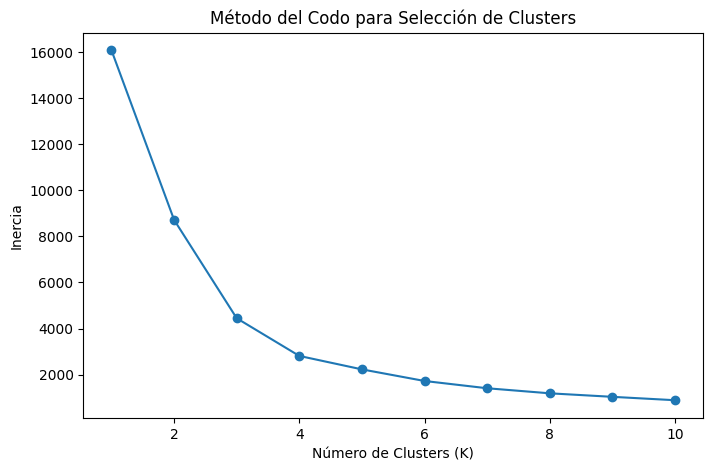

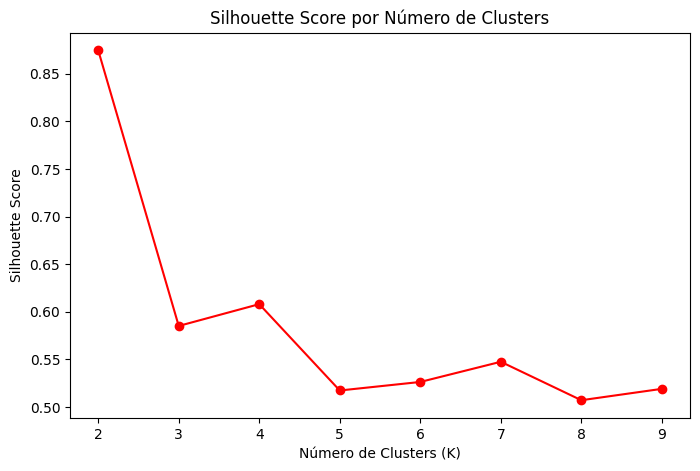

Valores de Silhouette Score: [(2, 0.875), (3, 0.585), (4, 0.608), (5, 0.517), (6, 0.526), (7, 0.548), (8, 0.507), (9, 0.519)]

Centroides (desescalados) y composite score de los clusters (K=5):


,recency,frequency,monetary,cluster,composite_score
0,1.034483,135.241379,360328.189655,3,360462.396552
1,2.022388,38.029851,101530.010908,2,101566.018371
2,4.115545,3.512210,7671.642233,1,7671.038898
3,20.960219,1.195425,3392.740745,0,3372.975951
4,11.656726,1.609675,3297.184409,4,3287.137358



Clientes con asignación de cluster descriptivo (K=5):


,customer,recency,frequency,monetary,cluster,cluster_label
0,+000.00Ebzs,13,2,3827.72,4,Cliente Perdido
1,+062.12Ebzs,23,1,1479.17,0,Clientes que Necesitan Atención
2,+131.34Ebzs,17,1,668.27,0,Clientes que Necesitan Atención
3,+304.68Ebzs,20,2,12142.59,0,Clientes que Necesitan Atención
4,+442.34Ebzs,1,10,13247.76,1,Cliente Prometedor
5,+503.56Ebzs,23,1,5507.83,0,Clientes que Necesitan Atención
6,+524.76Ebzs,1,8,14268.95,1,Cliente Prometedor
7,00025c4cbzs,9,2,1583.21,4,Cliente Perdido
8,001cdb6dbzs,20,2,6380.27,0,Clientes que Necesitan Atención
9,001f25aebzs,20,1,1153.45,0,Clientes que Necesitan Atención


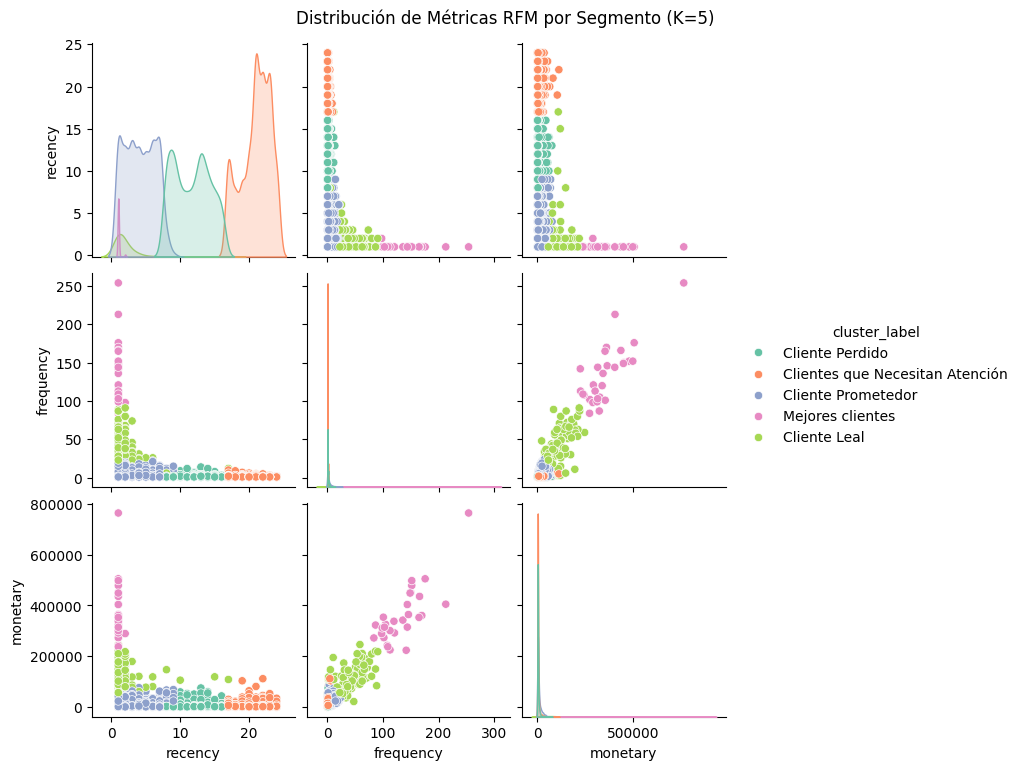

In [20]:
# =====================================================
# 0. Importaciones
# =====================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# =====================================================
# 1. Cálculo de Métricas RFM por Cliente
# =====================================================
# Aseguro que las fechas estén correctamente en formato datetime
df_orders['timestamp_created'] = pd.to_datetime(df_orders['timestamp_created'], errors='coerce')

# Defino la fecha de referencia como el día siguiente a la última compra registrada
reference_date = df_orders['timestamp_created'].max() + pd.Timedelta(days=1)

# Agrupo por 'customer' para obtener métricas RFM
df_rfm = df_orders.groupby('customer').agg({
    'timestamp_created': 'max',   # Última fecha de compra
    'order_id': 'count',          # Cantidad de órdenes
    'total_cobrado': 'sum'        # Suma total gastada
}).rename(columns={
    'timestamp_created': 'last_order_date',
    'order_id': 'frequency',
    'total_cobrado': 'monetary'
}).reset_index()

# Calculo la recency (días desde la última compra)
df_rfm['recency'] = (reference_date - df_rfm['last_order_date']).dt.days

# Me quedo con las columnas relevantes
df_rfm = df_rfm[['customer', 'recency', 'frequency', 'monetary']]
print("Métricas RFM por cliente:")
display(df_rfm.head())

# =====================================================
# 2. Normalización de las Variables RFM
# =====================================================
features = ['recency', 'frequency', 'monetary']
X = df_rfm[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =====================================================
# 3. Método del Codo (Elbow Method)
# =====================================================
inertias = []
K_range = range(1, 11)  # Probamos entre 1 y 10 clusters

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_scaled)
    inertias.append(kmeans_temp.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker="o", linestyle="-")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Inercia")
plt.title("Método del Codo para Selección de Clusters")
plt.show()

# =====================================================
# 4. Cálculo del Silhouette Score
# =====================================================
silhouette_scores = []
K_range_sil = range(2, 10)  # para silhouette se omite K=1

for k in K_range_sil:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels_temp)
    silhouette_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(K_range_sil, silhouette_scores, marker="o", linestyle="-", color="red")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score por Número de Clusters")
plt.show()

print("Valores de Silhouette Score:", list(zip(K_range_sil, np.round(silhouette_scores, 3))))

# =====================================================
# 5. Elección de Clusters = 5 (justificación)
# =====================================================
# Según el Método del Codo y el Silhouette Score, elegimos 5 clusters para una segmentación más detallada
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_rfm['cluster'] = kmeans.fit_predict(X_scaled)

# =====================================================
# 6. Interpretación y Etiquetado de los Clusters
# =====================================================
# Desescalo los centroides para entender mejor las métricas originales
centroids = kmeans.cluster_centers_
centroids_descaled = scaler.inverse_transform(centroids)

centroids_df = pd.DataFrame(centroids_descaled, columns=features)
centroids_df['cluster'] = centroids_df.index

# Calculamos un composite score: monetary + frequency - recency
centroids_df['composite_score'] = centroids_df['monetary'] + centroids_df['frequency'] - centroids_df['recency']

# Ordenamos los clusters de mayor a menor según composite_score
centroids_df_sorted = centroids_df.sort_values('composite_score', ascending=False).reset_index(drop=True)
print("\nCentroides (desescalados) y composite score de los clusters (K=5):")
display(centroids_df_sorted)

# =====================================================
# 7. Mapeo de Etiquetas (5 Clusters)
# =====================================================
# Se asignarán las etiquetas de mayor a menor composite_score:
#   - Mayor composite_score: "Mejores clientes"
#   - 2do: "Cliente Leal"
#   - 3er: "Cliente Prometedor"
#   - 4to: "Clientes que Necesitan Atención"
#   - Menor composite_score: "Cliente Perdido"

labels_mapping_ordered = {
    0: "Mejores clientes",
    1: "Cliente Leal",
    2: "Cliente Prometedor",
    3: "Clientes que Necesitan Atención",
    4: "Cliente Perdido"
}

# Genero el diccionario final de mapeo según el orden en centroids_df_sorted
final_label_mapping = {}
for i, row in centroids_df_sorted.iterrows():
    original_cluster = int(row['cluster'])
    final_label_mapping[original_cluster] = labels_mapping_ordered[i]

# Asigno las etiquetas finales a cada cliente
df_rfm['cluster_label'] = df_rfm['cluster'].map(final_label_mapping)

print("\nClientes con asignación de cluster descriptivo (K=5):")
display(df_rfm.head(10))

# =====================================================
# 8. Visualización de la Distribución de los Clusters
# =====================================================
sns.pairplot(df_rfm, vars=features, hue='cluster_label', palette='Set2')
plt.suptitle("Distribución de Métricas RFM por Segmento (K=5)", y=1.02)
plt.show()


In [21]:
# Exporta el DataFrame con los clientes clasificados a un archivo CSV
df_rfm.to_csv('clientes_clasificados.csv', index=False)
print("Archivo 'clientes_clasificados.csv' exportado exitosamente.")


Archivo 'clientes_clasificados.csv' exportado exitosamente.


In [22]:
# ======================================================
# Visualización Personalizada del Número de Clientes por Segmento (RFM)
# ======================================================
# En esta sección, creo un gráfico de barras para mostrar cuántos clientes
# hay en cada segmento RFM, pero aplico una personalización adicional 
# para que el resultado sea estéticamente más agradable y claro.

import plotly.express as px

# 1. Calculo la cantidad de clientes por etiqueta de cluster
cluster_counts = df_rfm['cluster_label'].value_counts().reset_index()
cluster_counts.columns = ['cluster_label', 'count']

# 2. Genero el gráfico de barras con Plotly Express
fig = px.bar(
    cluster_counts,
    x='cluster_label',
    y='count',
    title="Número de Clientes por Segmento (RFM)",
    labels={'cluster_label': 'Segmento', 'count': 'Número de Clientes'},
    text='count',                        # Muestra el valor arriba de cada barra
    template='plotly_white',             # Plantilla de estilo con fondo blanco
    color='cluster_label',               # Diferencia cada barra por su segmento
    color_discrete_sequence=px.colors.qualitative.Set2
)

# 3. Ajustes estéticos de las barras y textos
fig.update_traces(
    texttemplate='%{text}',
    textposition='outside',
    marker_line_color='black',           # Contorno negro en cada barra
    marker_line_width=1.5               # Grosor del contorno
)

# 4. Configuraciones generales del layout
fig.update_layout(
    height=600,                                         # Ajusta la altura del gráfico
    title_font=dict(size=22, family='Arial', color='darkblue'),
    xaxis_title_font=dict(size=16, family='Arial', color='black'),
    yaxis_title_font=dict(size=16, family='Arial', color='black'),
    font=dict(family='Arial', size=14, color='black'),
    plot_bgcolor='white',
    xaxis=dict(showgrid=False),                         # Oculta líneas de cuadrícula verticales
    yaxis=dict(showgrid=True, gridcolor='lightgrey'),   # Muestra líneas de cuadrícula horizontales
    margin=dict(l=60, r=60, t=80, b=60)
)

# 5. Muestro el gráfico final
fig.show()


In [23]:
import plotly.express as px

fig = px.pie(
    cluster_counts,
    names='cluster_label',
    values='count',
    title="Distribución de Clientes por Segmento (RFM)",
    hole=0.4,  # Tamaño del agujero para el estilo "donut"
    template='plotly_white',
    color='cluster_label',
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig.update_traces(
    textinfo='percent',      # Muestra únicamente el porcentaje
    textposition='inside',   # Coloca el texto en el interior de cada porción
    textfont_size=14
)

fig.update_layout(
    annotations=[
        dict(
            text='',
            x=0.5,
            y=0.5,
            font_size=16,
            showarrow=False
        )
    ],
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5
    ),
    margin=dict(l=50, r=50, t=50, b=50)
)

fig.show()


In [24]:
# ======================================================
# Visualización de la Contribución al Ingreso por Segmento
# ======================================================
# En esta sección, agrupo los clientes por su segmento (cluster_label)
# y sumo el total del gasto (monetary) para cada grupo. Así puedo ver
# qué porcentaje del ingreso total proviene de cada segmento.

# 1. Agrupar por 'cluster_label' y sumar el gasto total (monetary)
cluster_revenue = df_rfm.groupby('cluster_label').agg({'monetary': 'sum'}).reset_index()

# 2. Calcular el ingreso total de todos los segmentos
total_revenue = cluster_revenue['monetary'].sum()

# 3. Determinar el porcentaje que aporta cada segmento al ingreso total
cluster_revenue['percentage'] = (cluster_revenue['monetary'] / total_revenue) * 100

# 4. Ordenar de mayor a menor en función del ingreso
cluster_revenue = cluster_revenue.sort_values('monetary', ascending=False)

# 5. Creo un gráfico de barras con Plotly para mostrar:
#    - Eje X: Segmento (cluster_label)
#    - Eje Y: Ingreso (monetary)
#    - Texto: Porcentaje de contribución
fig = px.bar(
    cluster_revenue, 
    x='cluster_label', 
    y='monetary', 
    text='percentage', 
    title="Contribución al Ingreso Total por Segmento",
    labels={'monetary': 'Ingreso Total', 'cluster_label': 'Segmento'},
    template='plotly_white',
    color='cluster_label',
    color_discrete_sequence=px.colors.qualitative.Set2
)

# Ajustes estéticos de las trazas:
# - Se muestra el porcentaje con dos decimales sobre la barra
# - Se define un contorno negro y cierto grosor para darle más destaque
fig.update_traces(
    texttemplate='%{text:.2f}%',  # Muestra el valor numérico con 2 decimales y un símbolo %
    textposition='outside',
    marker_line_color='black', 
    marker_line_width=1.5
)

# Personalizo el layout (fuentes, márgenes, etc.) para que el gráfico sea más legible
fig.update_layout(
    height=700,
    title_font=dict(size=22, family='Arial', color='darkblue'),
    xaxis_title_font=dict(size=18, family='Arial', color='black'),
    yaxis_title_font=dict(size=18, family='Arial', color='black'),
    margin=dict(l=60, r=60, t=120, b=100),
    font=dict(family='Arial', size=16, color='black'),
    legend_title_font=dict(size=16, family='Arial', color='black'),
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, automargin=True),
    yaxis=dict(showgrid=True, gridcolor='lightgrey', automargin=True)
)

# Muestro el gráfico final
fig.show()
